# Let's load a dataset and try training!

To execute this notebook, you must have followed the steps in init.ipynb in data/ in order to have the data downloaded.

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset,random_split
from einops import rearrange
from torch.optim import Adam
from pathlib import Path
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import sys

sys.path.append('../')
from scripts import forward_process as fp, reverse_process as rp, train, util
from scripts import customUNet as unet

C:\Users\bmwhi\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
ab1 = np.load("../data/image-colorization/ab/ab/ab1.npy")
ab2 = np.load("../data/image-colorization/ab/ab/ab2.npy")
ab3 = np.load("../data/image-colorization/ab/ab/ab3.npy")
l = np.load("../data/image-colorization/l/gray_scale.npy")

ab = np.concatenate((ab1,ab2,ab3),axis=0)

def create_lab(n):
    lab= np.zeros((n,224,224,3))
    lab[:,:,:,0] = l[0:n:]
    lab[:,:,:,1:] = ab[0:n:]  
    return lab.astype("uint8")

## Let's load training dataset

Let's load only 2000 images here (our computer can't handle more in memory). The rest of the dataset can then be used for training. We are aware that much more data is necessary to train such a big model, and that we should have train/test/val sets with much more data in the train set. But for lack of time, we will try to train the model on 2000 images to produce results.

In [3]:
n=2000
size=64
batch_size=25

lab = create_lab(n)

# Resize and normalize pictures between -1 and 1
resized = []
for i in lab:
    img = cv2.normalize(i, None, alpha = -1, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    resized.append(cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC))

lab = torch.tensor(np.array(resized))
# Reshape so the tensor has the right shape for training
lab = rearrange(lab,"b h w c-> b c h w")
lab.shape

torch.Size([2000, 3, 64, 64])

In [4]:
# Extract the grayscale (l) color channel
gray = lab[:,0,:,:,None]
# Tripple the last dimension so it is the same shape as the color image
gray = gray.expand(gray.shape[0],gray.shape[1],gray.shape[2],3)
gray = rearrange(gray,"b h w c-> b c h w")
gray.shape

torch.Size([2000, 3, 64, 64])

In [5]:
# Create pairs of data (lab,gray)
data=[]
for i in range(len(lab)):
    data.append([lab[i],gray[i]])

In [6]:
# Load it in a dataloader 
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)  

# Start training

In [7]:
T = 500
epochs = 20
model = unet.CustomConditionalUNet()
diffTerms = util.ConstantDiffusionTerms(T, fp.linear_beta_schedule)
device = util.set_device()
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-5)

In [8]:
loss = train.train(epochs,device,optimizer,dataloader,batch_size,T, diffTerms,model)

Step 0 of epoch 0: Loss=0.984612226486206
Step 10 of epoch 0: Loss=0.8744279742240906
Step 20 of epoch 0: Loss=0.8550435304641724
Step 30 of epoch 0: Loss=0.8414549827575684
Step 40 of epoch 0: Loss=0.830522894859314
Step 50 of epoch 0: Loss=0.8240552544593811
Step 60 of epoch 0: Loss=0.8176493048667908
Step 70 of epoch 0: Loss=0.8136706352233887
Step 0 of epoch 1: Loss=0.8168551325798035
Step 10 of epoch 1: Loss=0.8124350309371948
Step 20 of epoch 1: Loss=0.8098756074905396
Step 30 of epoch 1: Loss=0.8087993264198303
Step 40 of epoch 1: Loss=0.8061398267745972
Step 50 of epoch 1: Loss=0.8091287016868591
Step 60 of epoch 1: Loss=0.8088787198066711
Step 70 of epoch 1: Loss=0.8066475987434387
Step 0 of epoch 2: Loss=0.8077587485313416
Step 10 of epoch 2: Loss=0.8065377473831177
Step 20 of epoch 2: Loss=0.804442286491394
Step 30 of epoch 2: Loss=0.805036187171936
Step 40 of epoch 2: Loss=0.8042275905609131
Step 50 of epoch 2: Loss=0.8036392331123352
Step 60 of epoch 2: Loss=0.805017828941

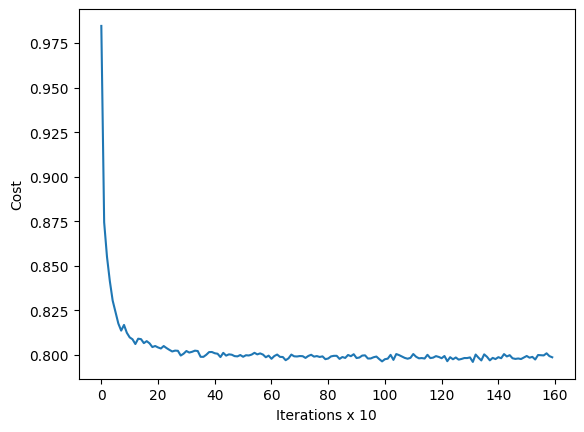

In [9]:
for i in range(len(loss)):
    loss[i] = loss[i].detach()

def plot_costs(costs):
    plt.plot(costs)
    plt.xlabel("Iterations x 10")
    plt.ylabel("Cost")
    plt.show()
    
plot_costs(loss)

In [10]:
torch.save(model.state_dict(), "../models/modelv2.pth")